# Pretrain CNN
July 12th, 2024

*Chen, S., Thielk, M., & Gentner, T. Q. (2024). Auditory Feature-based Perceptual Distance. bioRxiv, 2024.02.28.582631. https://doi.org/10.1101/2024.02.28.582631*

### Overview of Auditory Feature-based Perceptual Distance (APD):
1. Convert audio files to species-specific frequency scaled spectrogram 
2. Pre-train convolutional neural network (CNN) to learn spectrogram features **(You are here!)**
    - Import Spectrograms
    - Define CNN Inputs/Outputs
    - Define Training/Val Split
    - Define CNN Architecture
    - Fit the Model to the Data
    

3. Fine-tune CNN with behavioral data

## Import Spectrograms
These are the spectrograms from 0_ConvertStarScale.ipynb

In [1]:
import pandas as pd
import os
from apd.utils.paths import DATA_DIR

In [2]:
spec_p = os.path.join(DATA_DIR, 'interim', 'stable_length', 'spec.p')
print(spec_p)

/mnt/cube/j8xing/kai_apd/data/interim/stable_length/spec.p


In [3]:
spec_p = pd.read_pickle(spec_p)

In [4]:
spec_p.head()

,seg,bID,spec
0,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B338,"[[-0.57923824, -0.6018052, -0.67933035, -0.884..."
1,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B338,"[[-0.5489464, -0.5801697, -0.69067365, -0.7412..."
2,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B338,"[[-0.73662823, -0.6833033, -0.6459592, -0.7130..."
3,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B338,"[[-0.39315906, -0.41919217, -0.48941904, -0.62..."
4,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B338,"[[-0.5605774, -0.58246267, -0.6526525, -0.8680..."


In [5]:
spec_h, spec_w = spec_p.spec[0].shape
print(spec_h, spec_w)

291 674


## Define CNN Inputs and Outputs

We have loaded 7000 spectrograms (500 x 14 birds) here. 

To get the training inputs and outputs for the spectrographic jigsaw task, here are some considerations:
1. We will need to divide up the "star" feature scale into four parts, shuffle them, and leave an "answer key" output for their canonical order. We want the network to be able to come up with this "answer key" from shuffled feature scales of each spectrogram. We designate here that each divided part is 55 "stars" long. 
2. In addition, in order to not feed in long slits of spectrgrams, we will also divide the time scale into three parts. This also increases our dataset size to 21000 (1500 x 14 birds). We designate here that each divided part is 224 timebins long. *Note: 224x224 is the default input size for VGG19.*
3. We will need three dimensions in the input, because we are using VGG19 which general follow RGB image conventions. 

We will be using here *trainingfuncs.slice_matrix*, which is a custom function that does all of the above. 

In [6]:
import apd.utils.trainingfuncs
import numpy as np
from tqdm import tqdm

2024-08-02 17:45:55.435296: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 17:45:55.435377: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 17:45:55.435418: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
INPUT_SHAPE = (55, 224) ## 55 feature bins and 224 time bins (224 = 674 // 3, ALSO vgg19 default)
SLICE_SHAPE = (4, 1) ## slice 4 along the feature bins axis

In [8]:
input_list, output_list = [], []

for spec in tqdm(spec_p.spec.values): ## for every spectrogram
    for i in range(3): ## we will need to process each of the three 224-lengthed timebin
        star_input, answer_output = apd.utils.trainingfuncs.slice_matrix(
            spec[:, i * INPUT_SHAPE[1]:(i + 1) * INPUT_SHAPE[1]], 
            n_slices = SLICE_SHAPE, 
            slice_shape = INPUT_SHAPE
        )
        input_list.append(star_input)
        output_list.append(answer_output)

  0%|          | 0/7000 [00:00<?, ?it/s]/tmp/ipykernel_2992873/2384239459.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  star_input, answer_output = apd.utils.trainingfuncs.slice_matrix(
100%|██████████| 7000/7000 [00:17<00:00, 396.36it/s]


In [9]:
np.array(input_list).shape

(21000, 4, 55, 224, 3)

In [10]:
np.array(output_list).shape

(21000, 4)

Now, we have 
- input: 21000 portions of 4-piece shuffled spectrographic jigsaw, each sized at 55 features and 224 timebins, in RGB format (duplicated three times). 
- output: 21000 portions of 4 value array of how the shuffled spectrographic jigsaw is supposed to be put together. 

### Demo of relationship between input and output

In [11]:
import librosa
import matplotlib.pyplot as plt

In [12]:
example_id = 0

In [13]:
## for demonstration purpose, we will read only one of the three RGB layers
example_input = np.transpose(input_list[example_id], (3, 0, 1, 2))[0] ## select input, select first layer
example_output = output_list[example_id] ## select output

In [14]:
example_input.shape

(4, 55, 224)

### Unsliced original spec

Text(0.5, 1.0, 'Original Spec')

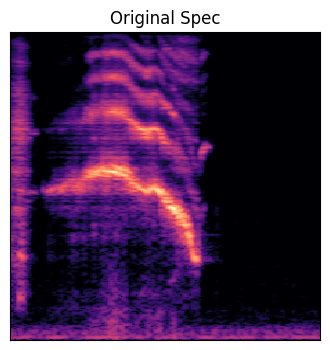

In [15]:
fig, ax = plt.subplots(figsize = (4, 4))
img = librosa.display.specshow(
    spec_p.spec[0][:, 0:224],
    hop_length = 256, ## hop_length of spec,
    sr = 44100
)
ax.set_title('Original Spec')

### Sliced shuffled pieces

Text(0.5, 0.98, 'Shuffled spec slices')

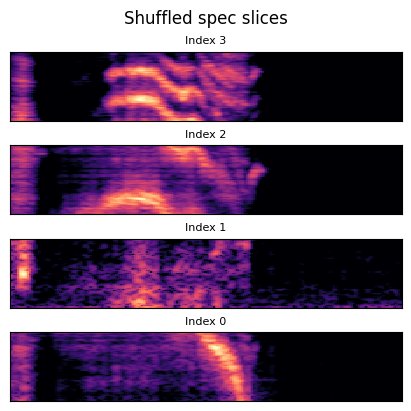

In [16]:
fig, axes = plt.subplots(figsize = (4, 4), nrows = 4, sharex = True, constrained_layout = True)
for loc, spec_slice in zip(range(len(example_input)), example_input):
    img = librosa.display.specshow(
        spec_slice,
        hop_length = 256,
        ax = axes[len(example_input) - 1 - loc] ## reverse order so that spec 0 is at the bottom, 3 is at top
    )
    axes[loc].set_title(f'Index {len(example_input) - loc - 1}', fontsize = 8)
fig.suptitle('Shuffled spec slices')

## Corrected order

In [17]:
example_output

array([1., 0., 2., 3.])

The example output contains the correct answer for the ordering; 
- the 0th indexed spec should be in the 0st index, 
- the 1st indexed spec should be in the 1th index,
- the 2nd indexed spec should be in the 3rd index,
- the 3rd indexed spec should be in the 2nd index. 

Text(0.5, 0.98, 'Correct spec order')

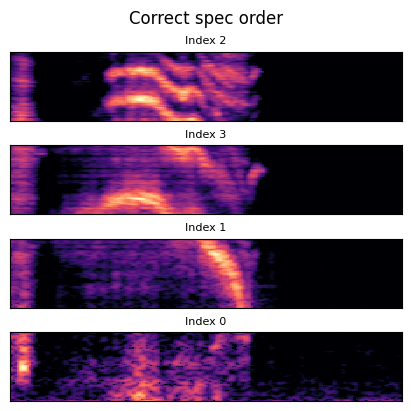

In [18]:
fig, axes = plt.subplots(figsize = (4, 4), nrows = 4, sharex = True, constrained_layout = True)
for loc, index in zip(range(len(example_input)), example_output):
    img = librosa.display.specshow(
        example_input[loc],
        hop_length = 256,
        ax = axes[len(example_input) - 1 - int(index)] 
        ## reverse order so that spec 0 is at the bottom, 3 is at top
    )
    axes[loc].set_title(f'Index {len(example_input) - int(index) - 1}', fontsize = 8)
fig.suptitle('Correct spec order')

#### The job of the CNN will simply be to reproduce the same relationship between input and output without the answerkey. 

## Define training and validation splits

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
input_train, input_val, output_train, output_val = train_test_split(
    input_list, output_list, test_size = 0.1, random_state = 0
)

In [21]:
print(f'Train size is {len(input_train)} \nValidation size is {len(input_val)}')

Train size is 18900 
Validation size is 2100


In [22]:
del spec_p
del input_list
del output_list ## since we made the splits for the CNN, we can clean up some memory

## Define CNN Model Architecture

### Import required modules

In [23]:
import tensorflow as tf

In [24]:
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session

In [25]:
clear_session()

In [26]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

In [27]:
try:
    tf.config.experimental.set_memory_growth(gpus[2], True) ## set to use memory dynamically
    tf.config.set_visible_devices([gpus[2]], 'GPU') ## only use gpu2
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

3 Physical GPUs, 1 Logical GPU


2024-08-02 17:46:42.987955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11471 MB memory:  -> device: 2, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:85:00.0, compute capability: 5.2


### Instantiate model

In [28]:
VGG19_INPUT_SHAPE = (224, 224, 3)

In [29]:
model = VGG19(
    include_top = False,
    weights = None,
    input_shape = VGG19_INPUT_SHAPE,
    pooling = 'avg'
)

### Prepare model input and connect layers

In [30]:
INPUT_SHAPE = np.array(input_train[0][0]).shape ## index 0th jigsaw, and index 0th slice
print(INPUT_SHAPE)

(55, 224, 3)


In [31]:
model_inputs = []
for i in range(np.prod(SLICE_SHAPE)):
    model_inputs.append(Input(shape = INPUT_SHAPE)) ## Add input layers that are the sizes of our spectrograms

In [32]:
model_inputs

[<KerasTensor: shape=(None, 55, 224, 3) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 55, 224, 3) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 55, 224, 3) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 55, 224, 3) dtype=float32 (created by layer 'input_5')>]

In [33]:
encodings = []

for i in range(np.prod(SLICE_SHAPE)):
    
    ## resize spectrograms to be 224 * 224 to match VGG19
    resized = layers.experimental.preprocessing.Resizing(
        224, 224, 
        interpolation = "bilinear"
    )(
        model_inputs[i] ## each model input is chained to a resizing layer
    )
    
    ## resizing layers are then connected to the VGG19 model, producing encodings
    encodings.append(model(resized)) 

## the encodings are connected to a concat layer
concated = layers.Concatenate(axis = 1)(encodings) 
    
## the concat layer is fed into a dense layer double its size
dense = layers.Dense(4096)(concated) 

## the dense layer is reduced to model output shape
model_output = layers.Dense(np.prod(SLICE_SHAPE))(dense) 

## collect everything from input to output
cfn = Model(model_inputs, model_output) 

In [34]:
cfn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 55, 224, 3)]         0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 55, 224, 3)]         0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 55, 224, 3)]         0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 55, 224, 3)]         0         []                            
                                                                                              

## Compile the model

We will use mean-squared error as our loss metric, and we will use the Adam optimization algorithm. 

From https://keras.io/api/optimizers/adam/:
Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order (mean) and second-order moments (the uncentered variance). 

The learning rate is how much the model changes in response to estimated error. 

In [35]:
cfn.compile(loss='mse', optimizer = Adam(0.000001), ) # specify adam optimization learning rate

## Train the model on spectrographic jigsaw task

In [36]:
from apd.utils.paths import MODEL_DIR, ensure_dir
import datetime

In [37]:
## Create location
pretrain_folder = os.path.join(MODEL_DIR, 'pretrain')
run_folder = os.path.join(pretrain_folder, '{:%Y_%m_%d_%H_%M_%S}'.format(datetime.datetime.now()))
ensure_dir(run_folder)
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model trained on spectral slicing of Starling songs in star scale, 4 slices')

In [38]:
print(run_folder)

/mnt/cube/j8xing/kai_apd/models/pretrain/2024_08_02_17_46_43


In [39]:
patience = 20
batch_size = 32
epochs = 1000

In [40]:
model_file = os.path.join(run_folder, 'weights-improvement.h5')
ensure_dir(model_file)

## add monitors
callbacks = [
    ## stop training when val_loss sees no improvement over 2000 epochs
    EarlyStopping(monitor='val_loss', patience=patience, verbose=1), 
    ## Only save best model with lowest val_loss
    ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True, verbose=0),
    ## Save loss info as CSV
    CSVLogger(os.path.join(run_folder, 'training.log'), separator=",", append=False)
]

## Fit the Model to the Data

#### Preprocess input and output data into generators
The amount of data exceeds the capacity of the training GPU. Using generators loads data incrementally, and is a good way of avoiding overloading the GPU memory. 

We will save data as a HDF5 file (which supports partial data loading), and pull them incrementally into GPU memory using generators. 

In [41]:
from apd.utils.DataGenerator import DataGenerator
import h5py as h5
import gc

In [42]:
training_h5 = os.path.join(DATA_DIR, 'interim', 'stable_length', 'train.hdf5')
validation_h5 = os.path.join(DATA_DIR, 'interim', 'stable_length', 'val.hdf5')

In [43]:
with h5.File(training_h5, 'w') as f:
    f.create_dataset('input_train', data = np.stack(input_train, axis = 0))
    f.create_dataset('output_train', data = np.stack(output_train, axis = 0))
with h5.File(validation_h5, 'w') as f:
    f.create_dataset('input_val', data = np.stack(input_val, axis = 0))
    f.create_dataset('output_val', data = np.stack(output_val, axis = 0))

In [44]:
training_h5_f = h5.File(training_h5, 'r')
validation_h5_f = h5.File(validation_h5, 'r')
gc.collect()

1005

In [45]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, f, X_name, y_name, batch_size):
        self.X_name, self.y_name = X_name, y_name
        self.batch_size = batch_size
        self.f = f
        
    def __len__(self):
        return int(np.ceil(self.f[self.X_name].shape[0] / float(self.batch_size)))
    
    def __getitem__(self, idx):
        X_batch = self.f[self.X_name][idx * self.batch_size : (idx + 1) * self.batch_size]
        y_batch = self.f[self.y_name][idx * self.batch_size : (idx + 1) * self.batch_size]
        
        X_batch = list(np.transpose(X_batch, (1, 0, 2, 3, 4)))
        
        return X_batch, y_batch

In [46]:
train_gen = DataGen(
    f = training_h5_f,
    X_name = 'input_train', 
    y_name = 'output_train', 
    batch_size = batch_size
)

val_gen = DataGen(
    f = validation_h5_f,
    X_name = 'input_val', 
    y_name = 'output_val', 
    batch_size = batch_size
)

### Fit model to data

In [ ]:
%%timeit -n 1 -r 1 ## run only once
cfn.fit(
    x = train_gen,
    callbacks = callbacks,
    epochs = epochs,
    validation_data = val_gen,
    verbose = 0 ## Expecting massive amount of epochs
    ## delegate verbosity to training.log in /models
)

2024-08-02 17:48:54.226766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-08-02 17:48:54.921894: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-02 17:48:57.341165: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-02 17:48:57.341269: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-02 17:48:57.482017: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate

### Quick Eval
#### Prediction Exemplar

In [50]:
cfn.load_weights(model_file)

In [51]:
prediction_val = cfn.predict(input_val_opt)

NameError: name 'input_val_opt' is not defined

In [ ]:
print(f'Exemplar Prediction {prediction_val[0]},\nExemplar Ground Truth {output_val_opt[0]}')

#### Validate Sample RMSE

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
np.sqrt(
    mean_squared_error(
        y_true = output_val_opt,
        y_pred = prediction_val
    )
)

## Round prediction to integers

In [52]:
np.sqrt(
    mean_squared_error(
        y_true = output_val_opt,
        y_pred = np.round(prediction_val)
    )
)

NameError: name 'mean_squared_error' is not defined